In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation, svm

%matplotlib inline
# plt.style.use('ggplot')

C:\Users\MattS\Anaconda3\envs\tfdeeplearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# HELPER FUNCTIONS

In [2]:
def read_data(file_path, column_names):
    """Reads the data from the specified file and retrieves the column names
    
    Args:
        file_path: The path of the file as a String
        column_names: Array of Strings representing the names of the colunms
        
    Returns:
        A DataFrame of the read in data
    """
    data = pd.read_csv(file_path, header = 0, names = column_names)
    return data

def feature_normalize(dataset):
    """Normalizes the data in the DataFrame using the mean and sigma values
    
    Args:
        dataset: The DataFrame to normalize
        
    Returns:
        The normalized data
    """
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset - mu) / sigma

def basic_feature_normalize(dataset, cols_to_norm):
    """A Basic Normalization of the dataset
    
    Takes the dataset and normalizes it from 0 (min value) to 1 (max value)
    
    Args:
        dataset: The DataFrame to normalize
        cols_to_norm: An Array of strings of the columns that need normalization
        
    Returns:
        The normalized dataset with the specified columns normalized between 0 and 1
    """
    dataset[cols_to_norm] = dataset[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return dataset

def make_rgbs(dataset, cols_to_rgb):
    """Takes a dataset and converts specific columns into rgb values
    
    Args:
        dataset: The DataFrame to convert to rgb values
        cols_to_rgb: An Arrya of strings of the columns that need to be converted
        
    Returns:
        The dataset with the specified columns converted to rgb values
    """
    dataset[cols_to_rgb] = dataset[cols_to_rgb].apply(lambda x: int(x * 255))
    return dataset

def convert_timestamp(dataset):
    """Converts the timestamp to a unix timestamp
    
    Args:
        dataset: The DataFrame with the timestamp column to convert to unix
        
    Returns:
        The dataset with the converted timestamp
    """
    dataset['Timestamp'] = dataset['Timestamp'].apply(lambda x:
                                                     datetime.strptime(x, '%m/%d/%y %H:%M').timestamp())
    return dataset

def convert_BGA_RFU(dataset, threshold):
    """Converts the BGA_Phycocyanin_RFU column to a true or false value (represented by 1 or 0)
       based on the threshold value
       
    Args:
        dataset: The DataFrame with the BGA_Phycocyanin_RFU value to be adjusted
        threshold: The minimum value for an algae bloom to be true
        
    Returns:
        The dataset with the converted BGA_RFU value"""
    dataset['BGA_Phycocyanin_RFU'] = dataset['BGA_Phycocyanin_RFU'].apply(lambda x: 1 if x >= threshold else 0)
    return dataset

# Batch Creation

In [3]:
# We step 50% down based on window size
def windows(data, size):
    counter_output = 0
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 12)
        counter_output += 1
        if counter_output % 10 == 0:
            print('Window Segmentation {0:.2f}% done'.format((start / data.count()) * 100))
    
# 32 chosen for 8 hours of 15 minute intervals
# TODO: NEED TO PASS IN COLUMNS AND DETERMINE FROM THAT
def segment_signal(dataset, window_size = 90, columns = 5):
    segments = np.empty((0, window_size, columns))
    labels = np.empty((0))
    count = 0;
    for (start, end) in windows(dataset["Timestamp"], window_size):
        temperature = dataset['Temperature'][start:end]
        conductivity = dataset['Sp_Cond'][start:end]
        turbidity = dataset['Turbidity'][start:end]
#         ph = dataset['pH'][start:end]
        odo = dataset['ODO'][start:end]
        if(len(dataset['Timestamp'][start:end]) == window_size):
            segments = np.vstack([segments, np.dstack([temperature, conductivity, turbidity, odo])])
            labels = np.append(labels, stats.mode(dataset['BGA_Phycocyanin_RFU'][start:end])[0][0])
    return segments, labels

# Setup the Lake_Dataset

In [4]:
cols = ['Temperature', 'Sp_Cond', 'pH_mV', 'pH', 'Turbidity', 'Chlorophyll', 'Chlorophyll_RFU',
        'ODOSat', 'ODO', 'BGA_Phycocyanin_RFU']

cols_to_keep = []
cols_to_keep.append('Turbidity')
# cols_to_keep.append('Sp_Cond')
# cols_to_keep.append('pH_mV')
# cols_to_keep.append('pH')
# cols_to_keep.append('Turbidity')
# cols_to_keep.append('Chlorophyll')
# cols_to_keep.append('Chlorophyll_RFU')
# cols_to_keep.append('ODOSat')
# cols_to_keep.append('ODO')
# cols_to_keep.append('BGA_Phycocyanin_RFU')

lake_dataset = read_data('./data/cleaned/bird_lake_combined_no_timestamp.csv', cols) 

for col in cols:
    if col not in cols_to_keep:
        lake_dataset = lake_dataset.drop(col, axis=1)
        
lake_dataset.head()

,Turbidity
0,31.00
1,31.06
2,27.66
3,28.36
4,27.69


In [5]:
forecast_out = int(300)
lake_dataset['Prediction'] = lake_dataset[['Turbidity']].shift(-forecast_out)

In [6]:
lake_dataset.head()

,Turbidity,Prediction
0,31.00,18.51
1,31.06,18.78
2,27.66,17.51
3,28.36,19.27
4,27.69,18.14


In [7]:
lake_dataset.tail()

,Turbidity,Prediction
32565,99.19,NaN
32566,95.70,NaN
32567,97.68,NaN
32568,95.90,NaN
32569,89.47,NaN


In [8]:
X = np.array(lake_dataset.drop(['Prediction'], 1))
X = preprocessing.scale(X)

In [9]:
X_forecast = X[-forecast_out:]
X = X[:-forecast_out]

In [10]:
y = np.array(lake_dataset['Prediction'])
y = y[:-forecast_out]

In [11]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size= 0.3)

In [12]:
clf = LinearRegression()
clf.fit(X_train, y_train)

confidence = clf.score(X_test, y_test)
print("confidence: ", confidence)

confidence:  0.0172386743131


In [13]:
X_forecast

array([[-0.0257743 ],
       [-0.02298624],
       [-0.0378559 ],
       [-0.02781888],
       [-0.05458426],
       [-0.07670287],
       [-0.08934208],
       [-0.09268775],
       [-0.07670287],
       [-0.09603343],
       [-0.10551283],
       [-0.10551283],
       [-0.11908139],
       [-0.09027144],
       [-0.11090308],
       [-0.11592159],
       [-0.11313353],
       [-0.146962  ],
       [-0.15290986],
       [-0.16127404],
       [-0.18227743],
       [-0.17893176],
       [-0.19881992],
       [-0.19473077],
       [-0.19435903],
       [-0.20699823],
       [-0.19733296],
       [-0.21982331],
       [-0.2224255 ],
       [-0.23041794],
       [-0.24194193],
       [-0.23023207],
       [-0.28617915],
       [-0.21461893],
       [-0.23097555],
       [-0.26982253],
       [-0.26183009],
       [-0.2776291 ],
       [-0.27781497],
       [-0.25235069],
       [-0.25142133],
       [-0.26759208],
       [-0.28357696],
       [-0.32019349],
       [-0.36182853],
       [-0

In [14]:
forecast_prediction = clf.predict(X_forecast)
print(forecast_prediction)

[ 55.00550637  55.02504769  54.92082734  54.99117607  54.80357944
  54.64855167  54.55996437  54.53651479  54.64855167  54.51306521
  54.44662474  54.44662474  54.35152366  54.5534506   54.40884486
  54.37367049  54.39321181  54.1561105   54.11442236  54.05579842
  53.90858717  53.93203675  53.79264203  53.82130262  53.82390813
  53.73532083  53.80306406  53.64543078  53.62719222  53.57117378
  53.49040301  53.57247653  53.18034746  53.6819079   53.56726552
  53.29498985  53.35100829  53.24027416  53.23897141  53.41744876
  53.42396253  53.3106229   53.19858602  52.9419434   52.65012642
  52.6592457   52.81687898  52.74522749  52.65664019  52.6162548
  52.64752091  52.58889696  52.49770415  52.57196116  52.98753981
  53.05137477  52.90416353  52.91719107  52.8077597   52.70353935
  52.6592457   52.77258533  52.79994317  52.86377814  52.96799849
  52.64621816  52.95887921  52.90676904  52.91588832  52.94845718
  53.10609046  53.05007202  53.12302627  53.01750316  53.11260423
  53.085246

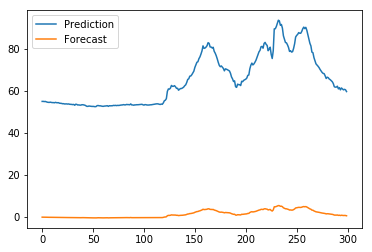

In [16]:
plt.plot(forecast_prediction, label="Prediction")
plt.plot(X_forecast, label="Forecast")
plt.legend()